Part A — Data preparation 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)


In [3]:
trades = pd.read_csv('../data/raw/historical_data.csv')
sentiment = pd.read_csv('../data/raw/fear_greed_index.csv')


In [4]:
print("Trader Data Shape:", trades.shape)
print("Sentiment Data Shape:", sentiment.shape)

print("\nTrader Data Info:")
display(trades.info())

print("\nSentiment Data Info:")
display(sentiment.info())


Trader Data Shape: (211224, 16)
Sentiment Data Shape: (2644, 4)

Trader Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null

None


Sentiment Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


None

In [5]:
# Missing values
trades_missing = trades.isna().sum()
sentiment_missing = sentiment.isna().sum()

# Duplicates
trades_duplicates = trades.duplicated().sum()
sentiment_duplicates = sentiment.duplicated().sum()

print("Trader missing values:\n", trades_missing)
print("\nSentiment missing values:\n", sentiment_missing)

print("\nTrader duplicates:", trades_duplicates)
print("Sentiment duplicates:", sentiment_duplicates)


Trader missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Sentiment missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Trader duplicates: 0
Sentiment duplicates: 0


In [ ]:
trades.columns


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [9]:
sentiment.columns

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Convert Trade Timestamp to Datetime

In [10]:
# Convert UNIX timestamp (milliseconds) to datetime
trades['trade_time'] = pd.to_datetime(trades['Timestamp'], unit='ms', errors='coerce')

# Extract date
trades['date'] = trades['trade_time'].dt.date


In [11]:
trades[['Timestamp', 'trade_time', 'date']].head()


,Timestamp,trade_time,date
0,1.730000e+12,2024-10-27 03:33:20,2024-10-27
1,1.730000e+12,2024-10-27 03:33:20,2024-10-27
2,1.730000e+12,2024-10-27 03:33:20,2024-10-27
3,1.730000e+12,2024-10-27 03:33:20,2024-10-27
4,1.730000e+12,2024-10-27 03:33:20,2024-10-27


Convert Sentiment Date Column

In [12]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [13]:
sentiment.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [14]:
print("Trade data date range:")
print(trades['date'].min(), "to", trades['date'].max())

print("\nSentiment data date range:")
print(sentiment['date'].min(), "to", sentiment['date'].max())


Trade data date range:
2023-03-28 to 2025-06-15

Sentiment data date range:
2018-02-01 to 2025-05-02


In [15]:
trades[['Account', 'Coin', 'Side', 'Closed PnL', 'date']].sample(5)


,Account,Coin,Side,Closed PnL,date
21852,0x4f93fead39b70a1824f981a54d4e55b278e9f760,ETH,BUY,0.00000,2024-03-09
38239,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,TRUMP,BUY,38.59170,2025-06-15
127900,0x47add9a56df66b524d5e2c1993a43cde53b6ed85,SUI,BUY,15.56442,2025-02-19
16983,0x083384f897ee0f19899168e3b1bec365f52a9012,ETH,SELL,0.00000,2025-02-19
26222,0x4f93fead39b70a1824f981a54d4e55b278e9f760,BTC,BUY,0.00000,2025-02-19


Part A — Feature Engineering (Daily Trader Metrics)

In [16]:
daily_metrics = (
    trades
    .groupby(['Account', 'date'])
    .agg(
        daily_pnl=('Closed PnL', 'sum'),
        trades_per_day=('Closed PnL', 'count'),
        avg_trade_size_usd=('Size USD', 'mean'),
        long_ratio=('Side', lambda x: (x == 'Buy').mean())
    )
    .reset_index()
)


In [17]:
daily_metrics.head()


,Account,date,daily_pnl,trades_per_day,avg_trade_size_usd,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,14810.891818,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,16345.241940,0.0
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,2492.749906,0.0
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,1693.351684,0.0
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,1533.468395,0.0


In [18]:
daily_metrics.shape


(102, 6)

In [19]:
daily_metrics = daily_metrics.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)


In [21]:
daily_metrics.head()

,Account,date,daily_pnl,trades_per_day,avg_trade_size_usd,long_ratio,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,14810.891818,0.0,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,16345.241940,0.0,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,2492.749906,0.0,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,1693.351684,0.0,Fear
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,1533.468395,0.0,NaN


In [20]:
daily_metrics['classification'].value_counts(dropna=False)


classification
Greed            32
Fear             32
NaN              25
Neutral           8
Extreme Greed     5
Name: count, dtype: int64

Part B — Analysis

In [22]:
sentiment_summary = (
    daily_metrics
    .groupby('classification')
    .agg(
        avg_daily_pnl=('daily_pnl', 'mean'),
        median_daily_pnl=('daily_pnl', 'median'),
        win_rate=('daily_pnl', lambda x: (x > 0).mean()),
        avg_trades_per_day=('trades_per_day', 'mean'),
        avg_trade_size=('avg_trade_size_usd', 'mean')
    )
    .reset_index()
)

sentiment_summary


,classification,avg_daily_pnl,median_daily_pnl,win_rate,avg_trades_per_day,avg_trade_size
0,Extreme Greed,35393.098355,0.000000,0.40000,1392.40000,4344.447836
1,Fear,209372.662205,81389.682515,0.93750,4183.46875,5926.522723
2,Greed,99675.516731,35988.376437,0.84375,1134.03125,5839.310974
3,Neutral,19842.797260,-0.418640,0.50000,892.62500,3793.444161


PnL Distribution: Fear vs Greed

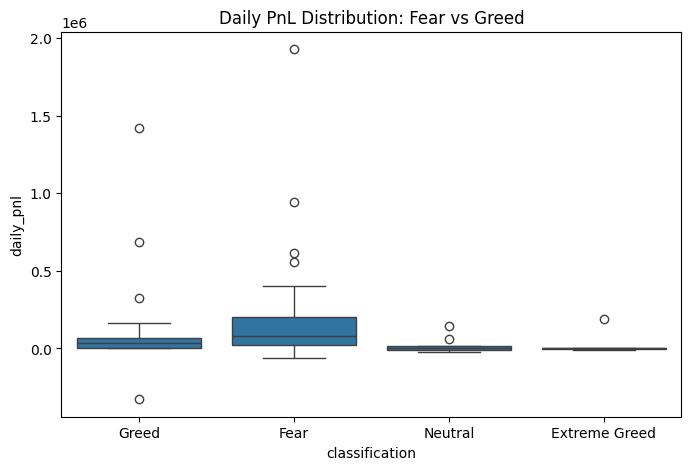

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(
    data=daily_metrics,
    x='classification',
    y='daily_pnl'
)
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()


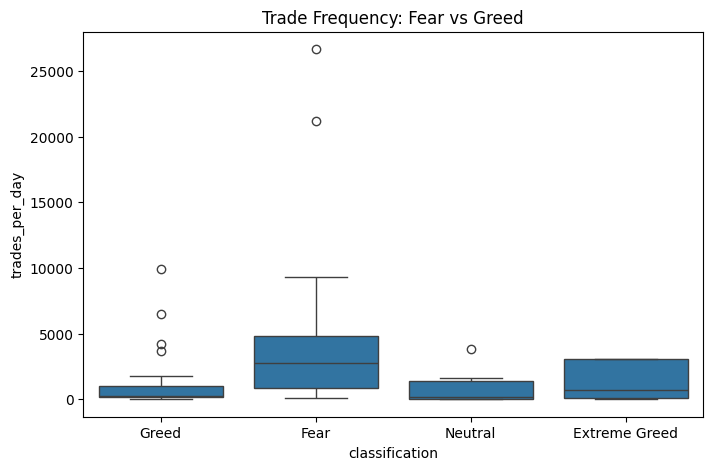

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=daily_metrics,
    x='classification',
    y='trades_per_day'
)
plt.title("Trade Frequency: Fear vs Greed")
plt.show()


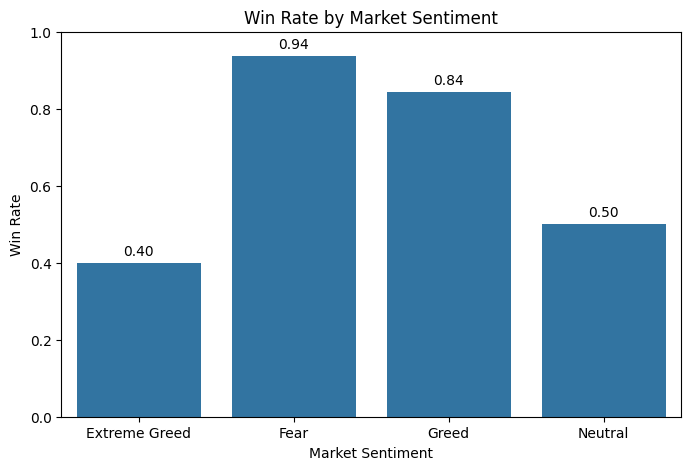

In [26]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=sentiment_summary,
    x='classification',
    y='win_rate'
)

plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.xlabel("Market Sentiment")
plt.ylim(0,1)

for i, v in enumerate(sentiment_summary['win_rate']):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


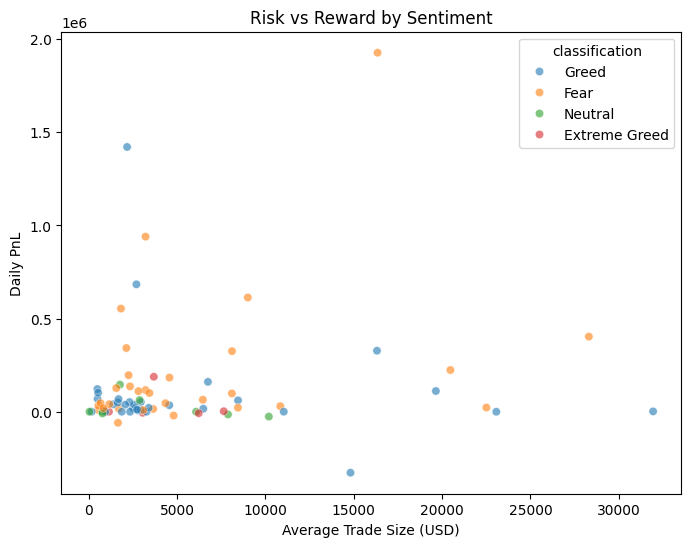

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=daily_metrics,
    x='avg_trade_size_usd',
    y='daily_pnl',
    hue='classification',
    alpha=0.6
)

plt.title("Risk vs Reward by Sentiment")
plt.xlabel("Average Trade Size (USD)")
plt.ylabel("Daily PnL")
plt.show()


Segment 1: Frequent vs Infrequent Traders

In [34]:
trader_activity = (
    daily_metrics
    .groupby('Account')
    .agg(
        avg_trades_per_day=('trades_per_day', 'mean')
    )
    .reset_index()
)


In [35]:
threshold = trader_activity['avg_trades_per_day'].median()

trader_activity['activity_segment'] = (
    trader_activity['avg_trades_per_day']
    .apply(lambda x: 'Frequent' if x >= threshold else 'Infrequent')
)


In [37]:
daily_metrics = daily_metrics.merge(
    trader_activity[['Account', 'activity_segment']],
    on='Account',
    how='left'
)


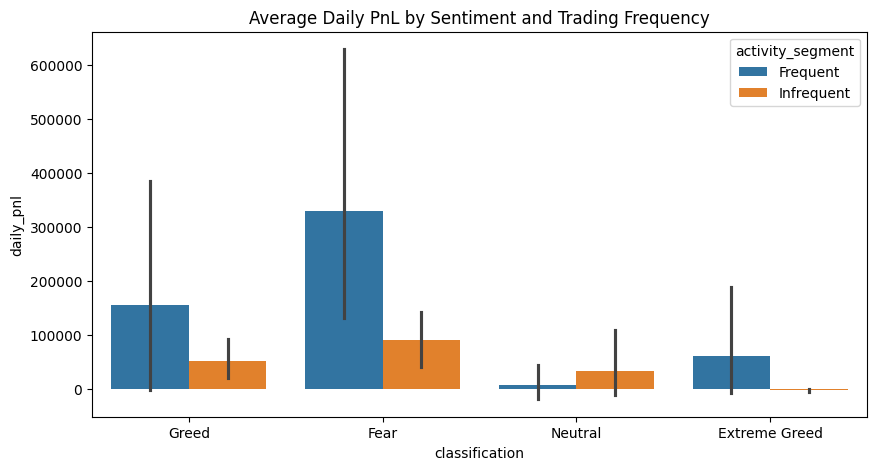

In [40]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=daily_metrics,
    x='classification',
    y='daily_pnl',
    hue='activity_segment'
)

plt.title("Average Daily PnL by Sentiment and Trading Frequency")
plt.show()



Segmentation 2: Consistent vs Inconsistent Traders

In [42]:
trader_consistency = (
    daily_metrics
    .groupby('Account')
    .agg(
        win_rate=('daily_pnl', lambda x: (x > 0).mean())
    )
    .reset_index()
)


In [43]:
win_threshold = trader_consistency['win_rate'].median()

trader_consistency['consistency_segment'] = (
    trader_consistency['win_rate']
    .apply(lambda x: 'Consistent' if x >= win_threshold else 'Inconsistent')
)


In [45]:
daily_metrics = daily_metrics.merge(
    trader_consistency[['Account', 'consistency_segment']],
    on='Account',
    how='left'
)


In [46]:
consistency_perf = (
    daily_metrics
    .groupby(['classification', 'consistency_segment'])
    .agg(
        avg_pnl=('daily_pnl', 'mean'),
        win_rate=('daily_pnl', lambda x: (x > 0).mean())
    )
    .reset_index()
)

consistency_perf


,classification,consistency_segment,avg_pnl,win_rate
0,Extreme Greed,Consistent,95224.489473,1.000000
1,Extreme Greed,Inconsistent,-4494.495724,0.000000
2,Fear,Consistent,166506.756489,1.000000
3,Fear,Inconsistent,291207.573119,0.818182
4,Greed,Consistent,160637.957936,1.000000
5,Greed,Inconsistent,10576.564200,0.615385
6,Neutral,Consistent,31293.172160,1.000000
7,Neutral,Inconsistent,16026.005626,0.333333


Part C — “Actionable output”

Strategy 1: Trade Aggressively Only During Fear 

Observation
Fear days show:

1. Highest average & median PnL
2. Highest win rate
3. Increased trade frequency

During Fear regimes, allow higher trade frequency and slightly larger position sizes, especially for frequent and consistent traders.

Strategy 2: Reduce Exposure During Extreme Greed

Observation
Extreme Greed has:
1. Lowest win rate
2. Zero median PnL
3. Profit concentrated among few traders

During Extreme Greed, reduce leverage and position size for most traders; only allow increased exposure for historically consistent winners.

Strategy 3: Segment-Aware Risk Controls

Observation
1. Frequent & consistent traders outperform across regimes
2. Infrequent traders underperform during high-volatility phases

Apply sentiment-aware risk limits: tighter limits for infrequent or inconsistent traders during Fear and Extreme Greed regimes.